In [2]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import useful_functions as uf
import density as den
import constants as cc
from scipy.interpolate import interp1d
import sys
sys.path.insert(0,'/home/zahra/hirax_tools/hirax_tools')
from array_config import HIRAXArrayConfig
from scipy.integrate import trapz
import pylab
from matplotlib.colors import LogNorm

In [3]:
cosmo=uf.cosmo

Mps_interpf=uf.Mps_interpf

n_points=40
n=n_points
z_r=6

x_e=1.

G=cc.G_const_Mpc_Msun_s/cc.M_sun_g

#rho_c=3*H0**2/(8.*np.pi*G)

rho_c=den.cosmo_densities(**cosmo)[0]*cc.M_sun_g #in units of g/Mpc^3

sigma_T=cc.sigma_T_Mpc

tau_r=0.055

T_rad=2.725 #In Kelvin

chi_r = uf.chi(z_r)

chi_m = uf.chi(1100)

chi_min=0.0001

k_min=1e-4

k_max=10

chi_array=np.linspace(chi_min,chi_m,n_points)

#tau_r=0.046*omega_b_0*h*x_e[np.sqrt(omega_M_0(1+z_r)**3+(1-omega_M_0))-1]

#get matter power spec data

mu_e=1.14

m_p=cc.m_p_g #in grams

rho_g0=cosmo['omega_b_0']*rho_c

#plt.loglog(uf.kabs,Mps_interpf(uf.kabs))

#plt.show()


zed=uf.zed

H=uf.H
chi=uf.chi
#chi_Z=chi(Z)
tau_inst=uf.tau_inst
f=uf.f
D=uf.D_1
r=uf.r
z=1.26
delta_z=0.005

In [4]:
ell=np.geomspace(2.,1.e4,n_points)
kperp_arr=ell/chi(z)
kpar_arr=np.geomspace(1.e-4,.15,n_points)
y=kpar_arr*r(z)

In [5]:

#kpar_min=uf.kpar_min(z,delta_z)

def ionized_elec(Yp,N_He):

    x=(1-Yp*(1-N_He/4))/(1-Yp/2)

    return x



def density(z,rho_g0):

    rho_g=rho_g0*(1+z)**3

    return rho_g



def ionized_electron_number(z):

    n=ionized_elec(0.24,1)*density(z,rho_g0)/(mu_e*m_p)

    return n



def tau(z):

    tau_der=sigma_T*cc.c_light_Mpc_s*ionized_electron_number(z)/((1+z)*uf.H(z))

    tau=sp.integrate.trapz(tau_der,z)

    return tau

x=ionized_elec(0.24,0)


In [6]:
def C_l_mu_integral(ell,z_min):
    Kp=np.geomspace(1.e-10,10.,n_points)
    Mu=np.linspace(-0.9999,0.9999,n_points)
    Z=np.geomspace(z_min,z_r,n_points)
    mu,kp,z=np.meshgrid(Mu,Kp,Z)
    H_z=uf.H(z)
    chi_z=uf.chi(z)
    #chi_Z=chi(Z)
    tau_z=uf.tau_inst(z)
    f_z=uf.f(z)
    D_z=uf.D_1(z)
    const=1e12*T_rad**2*x**2/cc.c_light_Mpc_s*(sigma_T*rho_g0/(mu_e*m_p))**2/8/np.pi**2
    #kp_norm=np.linalg.norm(Kp)
    #k_norm=np.linalg.norm(ell/chi_Z)
    theta_kp_arr=np.array([])
    theta_K_arr=np.array([])
    I_arr=np.array([])
    C_l=np.array([])
    for i in ell:
        k=i/chi_z
        K=np.sqrt(k**2+kp**2-2*k*kp*mu)
        theta_kp=np.sqrt(1-mu**2)
        theta_K=-np.sqrt(1-mu**2)*kp/K
        theta_kp_arr=np.append(theta_kp_arr,theta_kp)
        theta_K_arr=np.append(theta_K_arr,theta_K)
        I=theta_kp**2/kp**2+theta_K*theta_kp/K/kp
        I_arr=np.append(I_arr,I)
        #I=k*(k-2*kp*mu)*(1-mu**2)/K**2
        integral=[const*sp.integrate.trapz(sp.integrate.trapz(sp.integrate.trapz(kp**2*I*Mps_interpf(kp)*Mps_interpf(K)*(1+z)**2*np.exp(-2*tau_z)
        *f_z**2*D_z**4/chi_z**2*H_z,Mu,axis=0),Kp,axis=0),Z,axis=0)]
        C_l=np.append(C_l,integral)
    return C_l, theta_kp_arr, theta_K_arr, I_arr


In [7]:
redshift_min=z-delta_z
redshift_max=z+delta_z

In [8]:
#np.save('C_l_ksz_z_1pt26_deltaz_pt005_lower_100pts_2d',(ell,C_l_mu_integral(ell,redshift_min)[0]))
#np.save('C_l_ksz_z_1pt26_deltaz_pt005_upper_100pts_2d',(ell,C_l_mu_integral(ell,redshift_max)[0]))


In [11]:
OV_1pt26_lower=np.load('C_l_ksz_z_1pt26_deltaz_pt0015_lower_100pts_2d.npy')

OV_1pt26_upper=np.load('C_l_ksz_z_1pt26_deltaz_pt0015_upper_100pts_2d.npy')

ell_loaded=OV_1pt26_lower[0,:]
OV_1pt26_lower_loaded=OV_1pt26_lower[1,:]
OV_1pt26_upper_loaded=OV_1pt26_upper[1,:]


OV_1pt26_lower_interp=interp1d(ell_loaded,OV_1pt26_lower_loaded)
OV_1pt26_upper_interp=interp1d(ell_loaded,OV_1pt26_upper_loaded)

OV_interp=interp1d(ell_loaded,OV_1pt26_lower_interp(ell_loaded)-OV_1pt26_upper_interp(ell_loaded))


In [12]:
ell_large=np.geomspace(2.,1.e4,10000)
#np.save('cmb_spec_2_1e4_10000pts',(ell_large,cmb_spec(ell_large)))
#np.save('cmb_noise_2_1e4_10000pts',(ell_large,cmb_noise(ell_large)))
cmb_spec=np.load('cmb_spec_2_1e4_10000pts.npy')
cmb_noise=np.load('cmb_noise_2_1e4_10000pts.npy')
ell_cmb=cmb_spec[0,:]
cmb_spec_loaded=cmb_spec[1,:]
cmb_noise_loaded=cmb_noise[1,:]

cmb_spec_interp=interp1d(ell_cmb,cmb_spec_loaded)
cmb_noise_interp=interp1d(ell_cmb,cmb_noise_loaded)

In [14]:
def HiraxNoise(l,Ddish,Dsep,zi,delta_z): #the Dsep refers to the dish seperation including the dish diameter of 6. So we're assuming dishes are 1m away
        z_min=zi-delta_z
        z_max=zi+delta_z
        nu_21=1420
        nu_min=nu_21/(1+z_max) #743. #585. # #freq in MHz, these min and max values are based on HIRAX
        nu_max=nu_21/(1+z_min)#784. #665. #
        cp= HIRAXArrayConfig.from_n_elem_compact(1024,Dsep)
        nubar=(nu_min+nu_max)/2.

        Fov_deg=(cp.fov(frequency=nubar)) * ((180./np.pi)**2)
        Fov_str=(cp.fov(frequency=nubar))
        Tsys= 50. + 60.*((nubar/300.)**-2.5)
        lam=3.e8/(nubar*1.e6)
        Nbeam=1.
        npol=2.
        nu21=1420.e6
        Aeff=np.pi*((Ddish/2.)**2)*0.67
        Ttot=100.8e6 #36e6   4*365*24*3600.
        #Ttot=2*365*24*3600
        Sarea=15000.
        pconv=(chi(zi)**2)*r(zi)
        n_u=cp.baseline_density_spline(frequency=nubar)
        n=np.array([])
        for i in l:
            if n_u(i/(2.*np.pi))==0:
                n_u1=1/1e100
            else:
                n_u1=n_u(i/(2.*np.pi))
            n=np.append(n,n_u1)
        Nbs= 1024.*(1024.-1.)
        #norm=Nbs/sp.integrate.trapz(n*2*np.pi*(l/(2.*np.pi)), l/(2.*np.pi))
        C=n#*noprint (nu_min)
        A_bull= ((Tsys**2)*(lam**4)*Sarea) / (nu21*npol*Ttot*(Aeff**2)*Fov_deg*Nbeam)
        Warren=Tsys**2*lam**2/Aeff*4.*np.pi/(nu21*npol*Nbeam*Ttot)
        #return (Warren/C)*1e12
        return (A_bull/C)*1e12

ell_large=np.geomspace(1.e-10,1.e6,10000)
Hirax_noise_z_1pt26_deltaz_pt0015 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,1.26,0.0015), bounds_error=False)
Hirax_noise_z_1pt26_deltaz_pt015 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,1.26,0.015), bounds_error=False)
Hirax_noise_z_1pt26_deltaz_pt15 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,1.26,0.15), bounds_error=False)
Hirax_noise_z_1pt26_deltaz_1 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,1.26,1.), bounds_error=False)
Hirax_noise_z_2pt26_deltaz_pt0015 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,2.26,.0015), bounds_error=False)
Hirax_noise_z_pt9_deltaz_pt0015 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,.9,.0015), bounds_error=False)
Hirax_noise_z_1pt26_deltaz_pt005 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,1.26,0.005), bounds_error=False)

#Noise=Hirax_noise_z_1pt26_deltaz_pt0015
Noise=Hirax_noise_z_1pt26_deltaz_pt0015

In [190]:
#original cross corr
def crosscorr(ell,z_i,y, delta_z,kp_perp,kp_par): #with the assumption that zi=z so no cos factor, and we have dz=redshift bin width=2*delta_z defined above
    n=n_points #number of points over which to integrate
    #y=np.geomspace(1.,3000.,n)
    Z_min=z_i#-delta_z
    Z_max=z_i+2*delta_z
    z=np.geomspace(Z_min,Z_max,n)
    T_mean_zi=uf.T_mean(z_i)
    chi_zi=chi(z_i)
    chi_z=chi(z)
    f_zi=uf.f(z_i)
    f_z=uf.f(z)
    D_zi=uf.D_1(z_i)
    r_zi=uf.r(z_i)
    D_z=uf.D_1(z)
    H_zi=uf.H(z_i)
    H_z=uf.H(z)
    tau_z=uf.tau_inst(z)
    kpar=y/uf.r(z_i)
    const=1.e6/(4.*np.pi**2)*T_rad*T_mean_zi**2/cc.c_light_Mpc_s*f_zi*D_zi**2*H_zi/(chi_zi**2*r_zi)/(1.+z_i)*x*(sigma_T*rho_g0/(mu_e*m_p))
    #Cl=np.array([])
    k_perp=ell/chi_zi
    k=np.sqrt(k_perp**2+kpar**2)
    rsd=1.+f_zi*kpar**2/k**2
    kp=np.sqrt(kp_perp**2+kp_par**2)
    cos_theta=kp_par/kp #cos_theta=u, theta is azimuthal angle between k' and z (line of sight) axis
    sin_theta=kp_perp/kp
    sin_gamma=kpar/k #gamma is measured between k and xy plane, i.e. elevation of k
    cos_gamma=k_perp/k
    zeta=sin_gamma*cos_theta+cos_gamma*sin_theta
    k_dot_kp=k_perp*kp_perp+kpar*kp_par*zeta
    k_perp_dot_kp_perp=k_perp*kp_perp
    K=np.sqrt(k**2+kp**2-2*k_dot_kp)
    K_perp=np.sqrt(k_perp**2+kp_perp**2-2*k_perp_dot_kp_perp)
    theta_K=kpar/K/k**2*(k**2-k_dot_kp)-kp*k_perp*np.sqrt(np.abs(1-zeta**2))/k/K
    theta_kp=cos_theta

    #theta_kp=kpar*zeta/k+k_perp*np.sqrt(np.abs(1-zeta**2))/k
    #print (theta_K.min(),theta_K.max())
    #theta_K=np.where(theta_K > 0, theta_K, 0)
    I=theta_kp*(theta_kp/kp**2+theta_K/K/kp)
    #z_integral=sp.integrate.trapz(f_z*D_z**2*(1+z)*np.exp(-tau_z)*np.cos(kpar*cc.c_light_Mpc_s*z/H_z),z)
    arg=kpar*cc.c_light_Mpc_s*z/H_z
    cos_func=np.cos(arg)
    z_integral=sp.integrate.trapz(f_z*D_z**2*(1+z)*np.exp(-tau_z),z)
    integrand_1=z_integral*Mps_interpf(kp)*Mps_interpf(K)*rsd**2*theta_kp**2*kp_perp/kp**2
  #+theta_K/K/kp)#-mu*kp*np.gradient(Mps_interpf(k),axis=0))
    integrand_2=z_integral*Mps_interpf(kp)*Mps_interpf(K)*rsd**2*theta_kp*theta_K*kp_perp/kp/K

    #Cl=np.append(Cl,integral)
    return const*(integrand_1+integrand_2)


In [191]:
#original cross corr
def crosscorr_u_kp(ell,z_i,y, delta_z,u,kp): #with the assumption that zi=z so no cos factor, and we have dz=redshift bin width=2*delta_z defined above
    n=n_points #number of points over which to integrate
    #y=np.geomspace(1.,3000.,n)
    Z_min=z_i#-delta_z
    Z_max=z_i+2*delta_z
    z=np.geomspace(Z_min,Z_max,n)
    T_mean_zi=uf.T_mean(z_i)
    chi_zi=chi(z_i)
    chi_z=chi(z)
    f_zi=uf.f(z_i)
    f_z=uf.f(z)
    D_zi=uf.D_1(z_i)
    r_zi=uf.r(z_i)
    D_z=uf.D_1(z)
    H_zi=uf.H(z_i)
    H_z=uf.H(z)
    tau_z=uf.tau_inst(z)
    kpar=y/uf.r(z_i)
    const=1.e6/(4.*np.pi**2)*T_rad*T_mean_zi**2/cc.c_light_Mpc_s*f_zi*D_zi**2*H_zi/(chi_zi**2*r_zi)/(1.+z_i)*x*(sigma_T*rho_g0/(mu_e*m_p))
    #Cl=np.array([])
    k_perp=ell/chi_zi
    k=np.sqrt(k_perp**2+kpar**2)
    rsd=1.+f_zi*kpar**2/k**2
    
    
    kp_perp=kp*np.sqrt(1-u**2)
    '''
    for i in range(len(Noise_kp_perp)):
        if Noise_kp_perp[i]>1.e4:
            Noise_kp_perp[i]=0.
    '''
    #print (Noise_kp_perp.min(),Noise_kp_perp.max(),'Noise of kp perp')
    mock_arr=np.geomspace(2.e-2,6.e-1,n)
    #print (Noise(mock_arr*chi(z1)).min(),Noise(mock_arr*chi(z1)).max(),'Noise of mock arr')
    kp_par=kp*u
    theta_kp=u

    k_perp=ell/chi_zi
    k=np.sqrt(kpar**2+k_perp**2)
    zeta=(kpar/k*u+k_perp/k*np.sqrt(np.abs(1-u**2)))
    k_dot_kp=k_perp*kp_perp+kpar*kp_par*zeta
    kperp_dot_kp_perp=k_perp*kp_perp
    K_perp=k_perp
    K=np.sqrt(np.abs(k**2+kp**2-2*k_dot_kp))
    #K=k
    #print (theta_K.min())
    theta_K=kpar/K/k**2*(k**2-k_dot_kp)-kp*k_perp*np.sqrt(np.abs(1-zeta**2))/k/K
    #theta_K=kpar/k
    mu_k_sq=kpar**2/k**2

    #theta_kp=kpar*zeta/k+k_perp*np.sqrt(np.abs(1-zeta**2))/k
    #print (theta_K.min(),theta_K.max())
    #theta_K=np.where(theta_K > 0, theta_K, 0)
    I=theta_kp*(theta_kp/kp**2+theta_K/K/kp)
    #z_integral=sp.integrate.trapz(f_z*D_z**2*(1+z)*np.exp(-tau_z)*np.cos(kpar*cc.c_light_Mpc_s*z/H_z),z)
    arg=kpar*cc.c_light_Mpc_s*z/H_z
    cos_func=np.cos(arg)
    z_integral=sp.integrate.trapz(f_z*D_z**2*(1+z)*np.exp(-tau_z),z)
    integrand_1=z_integral*Mps_interpf(kp)*Mps_interpf(K)*rsd**2*theta_kp**2
  #+theta_K/K/kp)#-mu*kp*np.gradient(Mps_interpf(k),axis=0))
    integrand_2=z_integral*Mps_interpf(kp)*Mps_interpf(K)*rsd**2*theta_kp*theta_K*kp**2/kp/K

    #Cl=np.append(Cl,integral)
    return const*(integrand_1+integrand_2)


Taking the fourier transform to deal with the chi_ksz integral

In [192]:
loaded_fourier_arr=np.load('nu_and_kpar_fourier_dchi2_int_z_1pt26_deltaz_pt005_1000pts.npy')

nu=loaded_fourier_arr[0,:]
f_of_kpar_func=loaded_fourier_arr[1,:]

kpar_fourier_dchi2_int=interp1d(nu,f_of_kpar_func)

#cross corr with fourier transform
def crosscorr_fourier(ell,z_i,y, delta_z,kp_perp,kp_par): #with the assumption that zi=z so no cos factor, and we have dz=redshift bin width=2*delta_z defined above
    n=n_points #number of points over which to integrate
    #y=np.geomspace(1.,3000.,n)
    T_mean_zi=uf.T_mean(z_i)
    chi_zi=chi(z_i)
    chi_z=chi(z)
    f_zi=uf.f(z_i)
    f_z=uf.f(z)
    D_zi=uf.D_1(z_i)
    r_zi=uf.r(z_i)
    D_z=uf.D_1(z)
    H_zi=uf.H(z_i)
    H_z=uf.H(z)
    tau_z=uf.tau_inst(z)
    kpar=y/uf.r(z_i)
    const=1.e6/(4.*np.pi**2)*T_rad*T_mean_zi**2/cc.c_light_Mpc_s*f_zi*D_zi**2*H_zi/(chi_zi**2*r_zi)/(1.+z_i)*x*(sigma_T*rho_g0/(mu_e*m_p))
    #Cl=np.array([])
    k_perp=ell/chi_zi
    k=np.sqrt(k_perp**2+kpar**2)
    rsd=1.+f_zi*kpar**2/k**2
    kp=np.sqrt(kp_perp**2+kp_par**2)
    cos_theta=kp_par/kp #cos_theta=u, theta is azimuthal angle between k' and z (line of sight) axis
    sin_theta=kp_perp/kp
    sin_gamma=kpar/k #gamma is measured between k and xy plane, i.e. elevation of k
    cos_gamma=k_perp/k
    zeta=sin_gamma*cos_theta+cos_gamma*sin_theta
    k_dot_kp=k_perp*kp_perp+kpar*kp_par*zeta
    k_perp_dot_kp_perp=k_perp*kp_perp
    K=np.sqrt(k**2+kp**2-2*k_dot_kp)
    K_perp=np.sqrt(k_perp**2+kp_perp**2-2*k_perp_dot_kp_perp)
    theta_K=kpar/K/k**2*(k**2-k_dot_kp)-kp*k_perp*np.sqrt(np.abs(1-zeta**2))/k/K
    theta_kp=cos_theta
    z_integral=kpar_fourier_dchi2_int(kpar)
    #theta_kp=kpar*zeta/k+k_perp*np.sqrt(np.abs(1-zeta**2))/k
    #print (theta_K.min(),theta_K.max())
    #theta_K=np.where(theta_K > 0, theta_K, 0)
    I=theta_kp*(theta_kp/kp**2+theta_K/K/kp)
    #z_integral=sp.integrate.trapz(f_z*D_z**2*(1+z)*np.exp(-tau_z)*np.cos(kpar*cc.c_light_Mpc_s*z/H_z),z)
    integrand_1=z_integral*Mps_interpf(kp)*Mps_interpf(K)*rsd**2*theta_kp**2*kp_perp/kp**2
  #+theta_K/K/kp)#-mu*kp*np.gradient(Mps_interpf(k),axis=0))
    integrand_2=z_integral*Mps_interpf(kp)*Mps_interpf(K)*rsd**2*theta_kp*theta_K*kp_perp/kp/K

    #Cl=np.append(Cl,integral)
    return const*(integrand_1+integrand_2)




In [193]:
loaded_fourier_arr=np.load('nu_and_kpar_fourier_dchi2_int_z_1pt26_deltaz_pt005_1000pts.npy')

nu=loaded_fourier_arr[0,:]
f_of_kpar_func=loaded_fourier_arr[1,:]

kpar_fourier_dchi2_int=interp1d(nu,f_of_kpar_func)

def crosscorr_fourier_u_kp(ell,z_i,y, delta_z,u,kp): #with the assumption that zi=z so no cos factor, and we have dz=redshift bin width=2*delta_z defined above
    n=n_points #number of points over which to integrate
    #y=np.geomspace(1.,3000.,n)
    T_mean_zi=uf.T_mean(z_i)
    chi_zi=chi(z_i)
    chi_z=chi(z)
    f_zi=uf.f(z_i)
    f_z=uf.f(z)
    D_zi=uf.D_1(z_i)
    r_zi=uf.r(z_i)
    D_z=uf.D_1(z)
    H_zi=uf.H(z_i)
    H_z=uf.H(z)
    tau_z=uf.tau_inst(z)
    kpar=y/uf.r(z_i)
    const=1.e6/(4.*np.pi**2)*T_rad*T_mean_zi**2/cc.c_light_Mpc_s*f_zi*D_zi**2*H_zi/(chi_zi**2*r_zi)/(1.+z_i)*x*(sigma_T*rho_g0/(mu_e*m_p))
    #Cl=np.array([])
    k_perp=ell/chi_zi
    k=np.sqrt(k_perp**2+kpar**2)
    rsd=1.+f_zi*kpar**2/k**2
    
    
    kp_perp=kp*np.sqrt(1-u**2)
    '''
    for i in range(len(Noise_kp_perp)):
        if Noise_kp_perp[i]>1.e4:
            Noise_kp_perp[i]=0.
    '''
    #print (Noise_kp_perp.min(),Noise_kp_perp.max(),'Noise of kp perp')
    mock_arr=np.geomspace(2.e-2,6.e-1,n)
    #print (Noise(mock_arr*chi(z1)).min(),Noise(mock_arr*chi(z1)).max(),'Noise of mock arr')
    kp_par=kp*u
    theta_kp=u

    k_perp=ell/chi_zi
    k=np.sqrt(kpar**2+k_perp**2)
    zeta=(kpar/k*u+k_perp/k*np.sqrt(np.abs(1-u**2)))
    k_dot_kp=k_perp*kp_perp+kpar*kp_par*zeta
    kperp_dot_kp_perp=k_perp*kp_perp
    K_perp=k_perp
    K=np.sqrt(np.abs(k**2+kp**2-2*k_dot_kp))
    #K=k
    #print (theta_K.min())
    theta_K=kpar/K/k**2*(k**2-k_dot_kp)-kp*k_perp*np.sqrt(np.abs(1-zeta**2))/k/K
    #theta_K=kpar/k
    mu_k_sq=kpar**2/k**2

    #theta_kp=kpar*zeta/k+k_perp*np.sqrt(np.abs(1-zeta**2))/k
    #print (theta_K.min(),theta_K.max())
    #theta_K=np.where(theta_K > 0, theta_K, 0)
    I=theta_kp*(theta_kp/kp**2+theta_K/K/kp)
    #z_integral=sp.integrate.trapz(f_z*D_z**2*(1+z)*np.exp(-tau_z)*np.cos(kpar*cc.c_light_Mpc_s*z/H_z),z)
    z_integral=kpar_fourier_dchi2_int(kpar)
    integrand_1=z_integral*Mps_interpf(kp)*Mps_interpf(K)*rsd**2*theta_kp**2
  #+theta_K/K/kp)#-mu*kp*np.gradient(Mps_interpf(k),axis=0))
    integrand_2=z_integral*Mps_interpf(kp)*Mps_interpf(K)*rsd**2*theta_kp*theta_K*kp**2/kp/K

    #Cl=np.append(Cl,integral)
    return const*(integrand_1+integrand_2)


In [194]:
def Func_2d(ell,z,y,Func,delta_z):
    Func_mat=np.zeros((len(ell),len(y)))
    for i in range(len(ell)):
        for j in range(len(y)):
            Func_ind=Func(ell[i],z,y[j],delta_z)
            Func_mat[i][j]=Func_ind
    return Func_mat

def Func_noise(ell,z,y,Func,delta_z,Noise):
    Func_mat=np.zeros((len(ell),len(y)))
    for i in range(len(ell)):
        for j in range(len(y)):
            Func_ind=Func(ell[i],z,y[j],delta_z,Noise)
            Func_mat[i][j]=Func_ind
    return Func_mat


def Signal_integrated_fourier(ell,z,y,delta_z):
    Kp_perp=np.geomspace(1.e-6,1.,n)
    Kp_par=np.geomspace(1.e-6,.15,n)
    kp_perp,kp_par=np.meshgrid(Kp_perp,Kp_par)
    B=crosscorr_fourier(ell,z,y, delta_z,kp_perp,kp_par)
    integral=trapz(trapz(np.abs(B),Kp_perp,axis=0),Kp_par,axis=0)
    integral_sqrt=np.sqrt(np.abs(integral))
    return integral

def Signal_integrated_fourier_u_kp(ell,z,y,delta_z):
    U=np.linspace(-.9999,.9999,n)
    Kp=np.geomspace(1.e-6,1.,n)
    u,kp=np.meshgrid(U,Kp)
    B=crosscorr_fourier_u_kp(ell,z,y, delta_z,u,kp)
    integral=trapz(trapz(np.abs(B),U,axis=0),Kp,axis=0)
    integral_sqrt=np.sqrt(np.abs(integral))
    return integral

def Signal_orig(ell,z,y,delta_z):
    Kp_perp=np.geomspace(1.e-6,1.,n)
    Kp_par=np.geomspace(1.e-6,.15,n)
    kp_perp,kp_par=np.meshgrid(Kp_perp,Kp_par)
    B=crosscorr(ell,z,y, delta_z,kp_perp,kp_par)
    integral=trapz(trapz(np.abs(B),Kp_perp,axis=0),Kp_par,axis=0)
    integral_sqrt=np.sqrt(np.abs(integral))
    return integral

def Signal_orig_u_kp(ell,z,y,delta_z):
    U=np.linspace(-.9999,.9999,n)
    Kp=np.geomspace(1.e-6,1.,n)
    u,kp=np.meshgrid(U,Kp)
    B=crosscorr_u_kp(ell,z,y, delta_z,u,kp)
    integral=trapz(trapz(np.abs(B),U,axis=0),Kp,axis=0)
    integral_sqrt=np.sqrt(np.abs(integral))
    return integral

(1.26, 0.005)
(0.0001, 0.1)


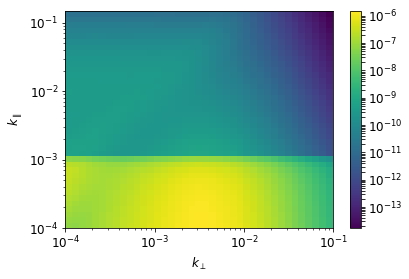

In [195]:
print (z,delta_z)
Z=Func_2d(ell,z,y,Signal_integrated_fourier_u_kp,delta_z)
Z=Z.T
kperp_arr=ell/chi(z)
kperp_arr=np.geomspace(1.e-4,1.e-1,n)
kpar_arr=y/r(z)
print (kperp_arr.min(),kperp_arr.max())
pylab.pcolormesh(kperp_arr,kpar_arr,Z,norm=LogNorm()) ;  cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
pylab.xlim([np.min(kperp_arr),np.max(kperp_arr)]) ; pylab.ylim([np.min(kpar_arr),np.max(kpar_arr)])
plt.xlabel(r'$k_\perp$',fontsize=12); plt.ylabel(r'$k_\parallel$',fontsize=12);
plt.xscale('log')
plt.yscale('log')
#plt.savefig('2D_bispec_fourier_z_1pt26_deltaz_pt005_and_below.png', dpi=300, bbox_inches='tight')
pylab.show()

In [16]:
def PN_integrals_no_redshift_int(ell,z_i,y , delta_z, Noise,u,kp):
    #Z_min=z_i-delta_z
    #Z_max=z_i+delta_z
    z1=z_i
    z2=z1

    T_mean=uf.T_mean
    chi_z1=chi(z1)
    f=uf.f
    D=uf.D_1
    r=uf.r
    H=uf.H

    kpar=y/r(z1)

    kp_perp=kp*np.sqrt(1-u**2)
    Noise_kp_perp=Noise(kp_perp*chi(z1))
    '''
    for i in range(len(Noise_kp_perp)):
        if Noise_kp_perp[i]>1.e4:
            Noise_kp_perp[i]=0.
    '''
    #print (Noise_kp_perp.min(),Noise_kp_perp.max(),'Noise of kp perp')
    mock_arr=np.geomspace(2.e-2,6.e-1,n)
    #print (Noise(mock_arr*chi(z1)).min(),Noise(mock_arr*chi(z1)).max(),'Noise of mock arr')
    kp_par=kp*u
    theta_kp=u

    const=1./(cc.c_light_Mpc_s**2*4*np.pi**2)
    k_perp=ell/chi_z1
    k=np.sqrt(kpar**2+k_perp**2)
    zeta=(kpar/k*u+k_perp/k*np.sqrt(np.abs(1-u**2)))
    k_dot_kp=k_perp*kp_perp+kpar*kp_par*zeta
    kperp_dot_kp_perp=k_perp*kp_perp
    K_perp=np.sqrt(k_perp**2+kp_perp**2-2*kperp_dot_kp_perp)
    K=np.sqrt(np.abs(k**2+kp**2-2*k_dot_kp))
    #K=k
    #print (theta_K.min())
    theta_K=kpar/K/k**2*(k**2-k_dot_kp)-kp*k_perp*np.sqrt(np.abs(1-zeta**2))/k/K
    #theta_K=kpar/k
    mu_k_sq=kpar**2/k**2
    rsd_1=1.+f(z1)*kpar**2/k**2
    rsd_2=1.+f(z2)*kpar**2/k**2
    Noise_Kperp=Noise(K_perp*chi(z1))
    #print (kp_perp.min())
    redshift_PP=T_mean(z1)**2*T_mean(z2)**2*f(z1)*f(z2)*rsd_1**2*rsd_2**2*H(z1)*H(z2)*D(z1)**2*D(z2)**2/(chi(z1)**2*r(z1)*(1+z1)*(1+z2))
    redshift_PN=T_mean(z1)*T_mean(z2)*rsd_1*rsd_2*f(z1)*f(z2)*H(z1)*H(z2)*D(z1)*D(z2)/((1+z1)*(1+z2))
    redshift_NN=f(z1)*f(z2)*H(z1)*H(z2)*chi(z1)**2*r(z1)/((1+z1)*(1+z2))
    
    integrand_P_deldel_P_vv=redshift_PP*theta_kp**2*Mps_interpf(kp)*Mps_interpf(K)
    integrand_P_delv_P_delv=redshift_PP*theta_kp*theta_K*kp**2*Mps_interpf(kp)*Mps_interpf(K)/K/kp
    integrand_P_vv_N_deldel=redshift_PN*theta_kp**2*Noise_Kperp*Mps_interpf(kp)
    integrand_P_deldel_N_vv=redshift_PN*theta_kp**2 *Noise_kp_perp *Mps_interpf(K)
    integrand_P_delv_N_delv_1=redshift_PN*theta_kp*theta_K *kp**2 *Noise_kp_perp *Mps_interpf(K)/K/kp
    integrand_P_delv_N_delv_2=redshift_PN*theta_kp*theta_K *kp**2 *Noise_Kperp*Mps_interpf(kp)/K/kp
    integrand_N_deldel_N_vv=redshift_NN*theta_kp**2 *Noise_kp_perp*Noise_Kperp
    integrand_N_delv_N_delv=redshift_NN*theta_kp*theta_K *kp**2/K/kp *Noise_kp_perp*Noise_Kperp


    P_integral_sum=const*(integrand_P_deldel_P_vv+integrand_P_delv_P_delv+integrand_P_vv_N_deldel+integrand_P_deldel_N_vv+integrand_P_delv_N_delv_1+integrand_P_delv_N_delv_2+integrand_N_deldel_N_vv+integrand_N_delv_N_delv)
    #P_integral_sum=integral_P_delv_N_delv_1
    return P_integral_sum


In [15]:
def PN_integrals_redshift_int(ell,z_i,y , delta_z, Noise,u,kp):
    Z_min=z_i-delta_z
    Z_max=z_i+delta_z
    z2=np.geomspace(Z_min,Z_max,n)
    z1=z_i

    T_mean=uf.T_mean
    chi_z1=chi(z1)
    f=uf.f
    D=uf.D_1
    r=uf.r
    H=uf.H

    kpar=y/r(z1)

    kp_perp=kp*np.sqrt(1-u**2)
    Noise_kp_perp=Noise(kp_perp*chi(z1))
    '''
    for i in range(len(Noise_kp_perp)):
        if Noise_kp_perp[i]>1.e4:
            Noise_kp_perp[i]=0.
    '''
    #print (Noise_kp_perp.min(),Noise_kp_perp.max(),'Noise of kp perp')
    mock_arr=np.geomspace(2.e-2,6.e-1,n)
    #print (Noise(mock_arr*chi(z1)).min(),Noise(mock_arr*chi(z1)).max(),'Noise of mock arr')
    kp_par=kp*u
    theta_kp=u

    const=1./(cc.c_light_Mpc_s**2*4*np.pi**2)
    k_perp=ell/chi_z1
    k=np.sqrt(kpar**2+k_perp**2)
    zeta=(kpar/k*u+k_perp/k*np.sqrt(np.abs(1-u**2)))
    k_dot_kp=k_perp*kp_perp+kpar*kp_par*zeta
    kperp_dot_kp_perp=k_perp*kp_perp
    K_perp=np.sqrt(k_perp**2+kp_perp**2-2*kperp_dot_kp_perp)
    K=np.sqrt(np.abs(k**2+kp**2-2*k_dot_kp))
    #K=k
    #print (theta_K.min())
    theta_K=kpar/K/k**2*(k**2-k_dot_kp)-kp*k_perp*np.sqrt(np.abs(1-zeta**2))/k/K
    #theta_K=kpar/k
    mu_k_sq=kpar**2/k**2
    rsd_1=1.+f(z1)*kpar**2/k**2
    rsd_2=1.+f(z2)*kpar**2/k**2
    Noise_Kperp=Noise(K_perp*chi(z1))
    #print (kp_perp.min())
    redshift_PP_z2=T_mean(z2)**2*f(z2)*rsd_2**2*H(z2)*D(z1)**2*D(z2)**2/(1+z2)
    redshift_PP=T_mean(z1)**2*f(z1)*rsd_1**2*H(z1)/(chi(z1)**2*r(z1)*(1+z1))*trapz(redshift_PP_z2,z2)
    redshift_PN_z2=T_mean(z2)*rsd_2*f(z2)*H(z2)*D(z2)/(1+z2)
    redshift_PN=T_mean(z1)*rsd_1*f(z1)*H(z1)*D(z1)/(1+z1)*trapz(redshift_PN_z2,z2)
    redshift_NN_z2=f(z2)*H(z2)/(1+z2)
    redshift_NN=f(z1)*H(z1)*chi(z1)**2*r(z1)/(1+z1)*trapz(redshift_NN_z2,z2)
    
    integrand_P_deldel_P_vv=redshift_PP*theta_kp**2*Mps_interpf(kp)*Mps_interpf(K)
    integrand_P_delv_P_delv=redshift_PP*theta_kp*theta_K*kp**2*Mps_interpf(kp)*Mps_interpf(K)/K/kp
    integrand_P_vv_N_deldel=redshift_PN*theta_kp**2*Noise_Kperp*Mps_interpf(kp)
    integrand_P_deldel_N_vv=redshift_PN*theta_kp**2 *Noise_kp_perp *Mps_interpf(K)
    integrand_P_delv_N_delv_1=redshift_PN*theta_kp*theta_K *kp**2 *Noise_kp_perp *Mps_interpf(K)/K/kp
    integrand_P_delv_N_delv_2=redshift_PN*theta_kp*theta_K *kp**2 *Noise_Kperp*Mps_interpf(kp)/K/kp
    integrand_N_deldel_N_vv=redshift_NN*theta_kp**2 *Noise_kp_perp*Noise_Kperp
    integrand_N_delv_N_delv=redshift_NN*theta_kp*theta_K *kp**2/K/kp *Noise_kp_perp*Noise_Kperp


    P_integral_sum=const*(integrand_P_deldel_P_vv+integrand_P_delv_P_delv+integrand_P_vv_N_deldel+integrand_P_deldel_N_vv+integrand_P_delv_N_delv_1+integrand_P_delv_N_delv_2+integrand_N_deldel_N_vv+integrand_N_delv_N_delv)
    #P_integral_sum=integral_P_delv_N_delv_1
    return P_integral_sum


In [19]:
def Func_2d(ell,z,y,Func,delta_z):
    Func_mat=np.zeros((len(ell),len(y)))
    for i in range(len(ell)):
        for j in range(len(y)):
            Func_ind=Func(ell[i],z,y[j],delta_z)
            Func_mat[i][j]=Func_ind
    return Func_mat

def Func_noise(ell,z,y,Func,delta_z,Noise):
    Func_mat=np.zeros((len(ell),len(y)))
    for i in range(len(ell)):
        for j in range(len(y)):
            Func_ind=Func(ell[i],z,y[j],delta_z,Noise)
            Func_mat[i][j]=Func_ind
    return Func_mat


In [ ]:
def SNR_optimal_u_kp_fourier(ell,z_arr,y,delta_z,Noise):
    U=np.linspace(-.9999,.9999,n)
    Kp=np.geomspace(1.e-6,1.,n)
    u,kp=np.meshgrid(U,Kp)
    B=crosscorr_fourier_u_kp(ell,z,y, delta_z,u,kp)
    Cl_p21_tot=PN_integrals_no_redshift_int(ell,z,y,delta_z, Noise,u,kp)
    Cl_pksz_tot=OV_interp(ell)+cmb_spec_interp(ell)+cmb_noise_interp(ell)
    SNR_sq=B**2/(np.abs(Cl_p21_tot))
    #Cl_pksz_tot_int=sp.integrate.trapz(1./Cl_pksz_tot,ell)
    integral=trapz(trapz(SNR_sq,U,axis=0),Kp,axis=0)/Cl_pksz_tot
    integral_sqrt=np.sqrt(integral)
    return integral_sqrt

In [96]:
def SNR_optimal_2d(ell,z_arr,y,delta_z,Noise):
    return Func_noise(ell,z_arr,y,SNR_optimal,delta_z,Noise)

In [17]:
def Inv_variance(ell,z,y,delta_z,Noise):
    #Kp_perp=np.geomspace(1.e-6,1.,n)
    #Kp_par=np.linspace(1.e-6,.15,n)
    #kp_perp,kp_par=np.meshgrid(Kp_perp,Kp_par)
    U=np.linspace(-.9999,.9999,n)
    Kp=np.geomspace(1.e-6,1.,n)
    u,kp=np.meshgrid(U,Kp)
    Cl_p21_tot=PN_integrals_no_redshift_int(ell,z,y,delta_z, Noise,u,kp)
    Cl_pksz_tot=OV_interp(ell)+cmb_spec_interp(ell)+cmb_noise_interp(ell)
    SNR_sq=1/(Cl_p21_tot)
    #Cl_pksz_tot_int=sp.integrate.trapz(1./Cl_pksz_tot,ell)
    integral=trapz(trapz(SNR_sq,U,axis=0),Kp,axis=0)/Cl_pksz_tot
    integral_sqrt=np.sqrt(np.abs(integral))
    return integral_sqrt 

In [20]:
kperp_arr=ell/chi(z)
kpar_arr=y/r(z)
#print (kperp_arr.min())
#ell_2d=np.outer(ell,np.ones(len(y)))
Z_inv_var=1./Func_noise(ell,z,y,Inv_variance,delta_z,Noise)
Z_inv_var=Z_inv_var.T


[[5.14157536e-01 6.90122753e-02 3.13286769e-02 ... 1.75314099e-03
  3.04090035e+45 5.62678180e+45]
 [7.60866925e-02 1.20649967e-01 4.80994632e-02 ... 1.75456303e-03
  3.04092631e+45 5.62680352e+45]
 [1.01499811e-01 2.77360546e-02 1.91893574e-02 ... 1.75627531e-03
  3.04095760e+45 5.62682970e+45]
 ...
 [2.22112896e+00 1.41167826e+00 8.91919334e-01 ... 1.26679397e-03
  3.06094794e+45 5.66173811e+45]
 [1.20129492e+00 9.52883358e-01 6.98393728e-01 ... 2.62344793e-03
  3.03668803e+45 5.65353491e+45]
 [1.86997277e+00 1.42356822e+00 1.01072629e+00 ... 1.59762035e-03
  2.99927746e+45 5.63314126e+45]]
1508


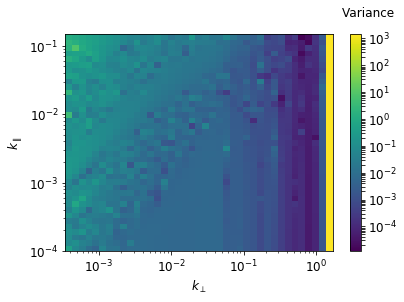

In [21]:
print (Z_inv_var)

Z_iv_var_max=len(Z_inv_var[Z_inv_var<1])
print (Z_iv_var_max)
pylab.pcolormesh(kperp_arr,kpar_arr,Z_inv_var,vmax=Z_iv_var_max,norm=LogNorm());  cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
#pylab.xlim([1.e-2,1]) ; #pylab.ylim([1.e-3,7.e-2])
plt.xlabel(r'$k_\perp$',fontsize=12); plt.ylabel(r'$k_\parallel$',fontsize=12); plt.title('Variance', x=1.13, y=1.05)
plt.xscale('log')
plt.yscale('log')
#plt.savefig('optimal_estimator_2D_var_z_1pt26_deltaz_pt003_kpmax_1.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
print (z)

1.26


In [25]:
def SNR_binned(z,delta_z,Noise,SNR,Sarea_deg,Dsep):
    z_min=z-delta_z
    z_max=z+delta_z
    nu_21=1420. #MHz
    nu_min=nu_21/(1+z_max) #743. #585. # #freq in MHz, these min and max values are based on HIRAX
    nu_max=nu_21/(1+z_min) #784. #665. #
    nubar=(nu_min+nu_max)/2.
    cp= HIRAXArrayConfig.from_n_elem_compact(1024,Dsep)
    Fov_str=(cp.fov(frequency=nubar))
    print (Fov_str,'fov')
    Sarea=Sarea_deg*(np.pi/180.)**2 #converting from square degrees to square radians
    print (Sarea,'sarea')
    fsky=Sarea/4./np.pi
    delta_nu_dimless=(nu_max-nu_min)/nu_21
    N_patches=Sarea/Fov_str
    Mode_Volume_Factor=fsky*Sarea*delta_nu_dimless*2
    num_k_bins_y=15
    num_k_bins_ell=25
    n=50
    kpar_arr = np.zeros(num_k_bins_y) ; kperp_arr= np.zeros(num_k_bins_ell) ; SNR_arr = np.zeros((num_k_bins_y,num_k_bins_ell))
    kpar_min = 0.01
    kperp_min =0.01
    delta_kpar = .01
    delta_kperp = .01
    y_min=kpar_min*r(z)
    ell_min=kperp_min*chi(z)
    delta_y=delta_kpar*r(z)
    delta_ell=delta_kperp*chi(z)
    y_arr=np.linspace(y_min,y_min+num_k_bins_y*delta_y,n)
    ell_arr=np.linspace(ell_min,ell_min+num_k_bins_ell*delta_ell,n)
    for bin_number_y in np.linspace(0,num_k_bins_y-1,num_k_bins_y):
        kpar_bin_min, kpar_bin_max = kpar_min + delta_kpar*np.array([bin_number_y, bin_number_y+1])    # bin_number starts at 0
        #print (kpar_bin_min*r(z),kpar_bin_max*r(z),'kpar')
        for bin_number_ell in np.linspace(0,num_k_bins_ell-1,num_k_bins_ell):
            kperp_bin_min, kperp_bin_max = kperp_min + delta_kperp*np.array([bin_number_ell, bin_number_ell+1])
            #print (kperp_bin_min*r(z),kperp_bin_max*r(z),'kperp')
            kpar_arr[np.int(bin_number_y)] = kpar_bin_min  ; kperp_arr[np.int(bin_number_ell)] = kperp_bin_min
            y_bin_arr = y_arr[(y_arr > kpar_bin_min*r(z)) & (y_arr < kpar_bin_max*r(z))]
            ell_bin_arr = ell_arr[(ell_arr > kperp_bin_min*chi(z)) & (ell_arr < kperp_bin_max*chi(z))]
            ell_bin_2d_arr=np.outer(ell_bin_arr,np.ones(len(y_bin_arr)))
            #SN_ratio_2d_arr = SNR(ell_bin_arr,y_bin_arr) #SNR(Ell,Y)
            SN_ratio_2d_arr=SNR(ell_bin_arr,z,y_bin_arr,delta_z,Noise)
            integrand=SN_ratio_2d_arr**2*ell_bin_2d_arr
            int1=sp.integrate.trapz(integrand, ell_bin_arr, axis=0)
            SNR_sq = 0.5 * Mode_Volume_Factor/(4.*np.pi**2)*N_patches * sp.integrate.trapz(int1, y_bin_arr, axis=0)
            SNR_arr[np.int(bin_number_y),np.int(bin_number_ell)] = np.sqrt(SNR_sq)
                # print 'kparmin=', kpar_bin_min, 'kperpmin=', kperp_bin_min, np.sqrt(SNR_sq)
    return kperp_arr,kpar_arr,SNR_arr


In [26]:
S_area=15000
SNR=SNR_optimal_2d
kperp_arr_snr,kpar_arr_snr,SNR_arr=SNR_binned(z, delta_z, Noise,SNR,S_area,Dsep=7.)
ell_snr=kperp_arr_snr*uf.chi(z)
print (kperp_arr_snr.min())

(<Quantity 0.00632375>, 'fov')
(4.5692612968006285, 'sarea')
0.01


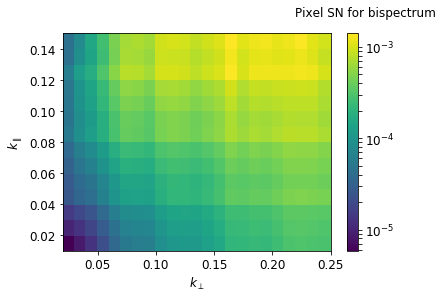

In [27]:
import pylab


#print (SNR_arr)
#print (np.cumsum(cum_SNR(SNR_arr)))

pylab.pcolormesh(kperp_arr_snr,kpar_arr_snr,SNR_arr,norm=LogNorm());  cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
pylab.xlim([np.min(kperp_arr_snr)+0.01,np.max(kperp_arr_snr)]) ; pylab.ylim([np.min(kpar_arr_snr),np.max(kpar_arr_snr)])
plt.xlabel(r'$k_\perp$',fontsize=12); plt.ylabel(r'$k_\parallel$',fontsize=12); plt.title('Pixel SN for bispectrum', x=1.13, y=1.05)
#plt.xscale('log')
#plt.yscale('log')
#plt.savefig('optimal_SN_2D_bispec_z_2pt26_deltaz_pt003_integrated_over_redshift_kp_perp_1_kp_par_pt15_kparmax_pt15.png', dpi=300, bbox_inches='tight')
pylab.show()


In [28]:
def cumulative_SNR(SNR_2D_binned):
    sum_each_kperp=np.array([])
    SNR_y,SNR_x=SNR_2D_binned.shape
    for i in range(SNR_x):
        sum_one_kperp=np.sum(SNR_2D_binned[:,i])
        sum_each_kperp=np.append(sum_each_kperp,sum_one_kperp)
    return sum_each_kperp


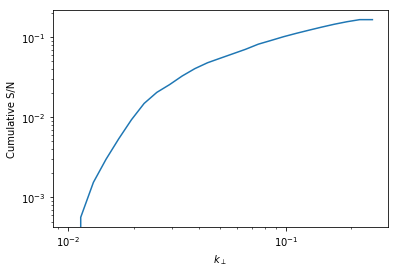

In [29]:
kperp_cumulative=np.geomspace(kperp_arr_snr.min(),kperp_arr_snr.max(),len(cumulative_SNR(SNR_arr)))
plt.loglog(kperp_cumulative,np.cumsum(cumulative_SNR(SNR_arr)))
plt.ylabel('Cumulative S/N')
plt.xlabel(r'$k_\perp$')
#plt.xlim(1.18e-2,1)
#plt.savefig('optimal_cum_SN_2D_bispec_z_2pt26_deltaz_pt003_integrated_over_redshift_kp_perp_1_kp_par_pt15_kparmax_pt15.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
a=np.geomspace(1.,10,10)
b=np.geomspace(5.,10,10)
c=np.geomspace(10.,20,10)

integrand=np.zeros((10,10,10))
for i in range(len(a)):
    for j in range(len(b)):
        for xo in range(len(c)):
            integrand[i][j][xo]=a[i]*b[j]*c[xo]

(trapz(integrand,c)).max()

In [ ]:
Z_min=z-delta_z
Z_max=z+delta_z
z1=np.geomspace(Z_min,Z_max,n)
T_mean_z1=uf.T_mean(z1)
chi_z1=chi(z1)
chi_z=chi(z)
f_z1=uf.f(z1)
D_z1=uf.D_1(z1)
r_z1=uf.r(z1)
H_z1=uf.H(z1)
tau_z1=uf.tau_inst(z1)

redshift_21cm=T_mean_z1**2*f_z1*D_z1**2*H_z1/(chi_z1**2*r_z1)/(1.+z1)
print (trapz(redshift_21cm,z1))


plt.plot(z1,redshift_21cm)
print (redshift_21cm)
plt.show()

z1=z
T_mean_z1=uf.T_mean(z1)
chi_z1=chi(z1)
chi_z=chi(z)
f_z1=uf.f(z1)
D_z1=uf.D_1(z1)
r_z1=uf.r(z1)
H_z1=uf.H(z1)
tau_z1=uf.tau_inst(z1)
redshift_21cm=T_mean_z1**2*f_z1*D_z1**2*H_z1/(chi_z1**2*r_z1)/(1.+z1)
print (redshift_21cm)